In [1]:
%matplotlib inline
import sys
import random
from math import floor
import numpy as np
import numpy.random as nr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os, glob, math,time
import multiprocessing
import sys

from scipy import misc
import torch
import torch as tc
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import transforms, utils
from torchvision import models
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

sys.path.append('/mnt/home/r120084/')
sys.path.append('/home/r120084/pytorch_lib/pytorch')
import lib.pytorch_trainer as ptt

In [2]:
use_gpu = torch.cuda.is_available()
cpu_count = multiprocessing.cpu_count()

print('GPU available:', use_gpu)
print('cpu_count: ', cpu_count)

GPU available: True
cpu_count:  24



# Choose dataset 

In [3]:
if use_gpu:
    path2train = "/mnt/home/e209440/data/train"
    path2test = "/mnt/home/e209440/data/test"
else:
    path2train = "/home/r120084/project/data/train"
    path2test = "/home/r120084/project/data/test"

In [4]:
labels = {  'c0' : 'safe driving', 
            'c1' : 'texting - right', 
            'c2' : 'talking on the phone - right', 
            'c3' : 'texting - left', 
            'c4' : 'talking on the phone - left', 
            'c5' : 'operating the radio', 
            'c6' : 'drinking', 
            'c7' : 'reaching behind', 
            'c8' : 'hair and makeup', 
            'c9' : 'talking to passenger'}

# Dataset Class with split data and transformations

In [5]:
class KaggleSafeDriverDataset(Dataset):
    """
    Arguments:
        path: Path to data (train or test) 
        use_only: Percentage of total data that will be used.
        transforms: PIL transforms to be perfomed on each item of get_item method
        is_test: Test data (boolean)
        is_val: Validation data (boolean)
        val_size: Size of validation data 
        
        **** The indices of Validation and Train dataset are shuffled****
        
    """

    def __init__(self, path, use_only =1.0, transforms=None, \
                 is_test=False,is_val=False,val_size=0.2):
    
        self.transform = transforms        
        
        if is_test:

            X_test    = []
            path  = os.path.join(path, '*.jpg')
            files = glob.glob(path)
            X_test.extend(files)  

            length = len(X_test)
            only = int(use_only * length)
            self.X = X_test[:only]
            
            self.y = None # In order to create the Dataloader of test data it has to have a y coordenate.
        
        else:

            X_train= []
            y_train = []
            for i, label in enumerate(labels):
                path_folder = os.path.join(path, str(label), '*.jpg')
                files = glob.glob(path_folder) 
                X_train.extend(files)
                y_train.extend([int(label[-1])]*len(files))

            length = len(X_train)
            indices = np.array((range(0,length)))
            
            nr.seed(4572)
            ind = nr.permutation(indices)
            
            
            length = ind.shape[0]
            only = int(use_only * length)
            
            ind = ind[:only]
            length = ind.shape[0]
                 
            split = int(val_size * length)
            
            if is_val:
                self.X = [X_train[i] for i in ind[:split]]
                self.y = [y_train[i] for i in ind[:split]]
 
            else:
                self.X = [X_train[i] for i in ind[split:]]
                self.y = [y_train[i] for i in ind[split:]]
    
    def __getitem__(self, index):
        path = self.X[index]
        label = self.y[index]
        with open(path, 'rb') as f:
            with Image.open(f) as img:
                 image = img.convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.X)
    

In [6]:
batch_size = 32
img_size ,img_width, img_height = 224, 224, 224
use_only = 0.1 # Use only is the percentage of the full dataset

In [7]:
def my_transforms(img, img_width=img_width, img_height=img_height):
    return img.resize((img_width, img_height))

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

def denormalize(image, mean=imagenet_mean, std=imagenet_std):
    inp = image.transpose((1, 2, 0))  # Channel Last
    img = std * inp + mean
    return img

In [8]:
# Data augmentation and normalization for training 
data_transforms = {
    'train': transforms.Compose([
#        transforms.RandomHorizontalFlip(), First try withouth Data Augmentation 
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'valid': transforms.Compose([
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}


In [9]:
dsets = {
    'train': KaggleSafeDriverDataset(path2train, transforms=data_transforms['train'],use_only=use_only),
    'valid': KaggleSafeDriverDataset(path2train, transforms=data_transforms['valid'],use_only=use_only, is_val=True, val_size=0.2),
    'test':  KaggleSafeDriverDataset(path2test, transforms=data_transforms['valid'],use_only=use_only, is_test=True),
}

In [131]:
def _create_dataLoader(dsets, batch_size, cpu_count, pin_memory =  False):
    dset_loaders = {}
    for key in dsets.keys():
        dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, shuffle=True, num_workers=2*cpu_count, pin_memory=pin_memory)

    return dset_loaders

In [11]:
pin_memory = False
if use_gpu:
    pin_memory = True

dset_loaders = _create_dataLoader(dsets, batch_size, cpu_count, pin_memory=pin_memory)

In [12]:
dset_sizes = {x: len(dsets[x]) for x in ['train','valid', 'test']} 
dset_classes = len(dsets['train'].y)
dset_classes, dset_sizes

# Datates has much more samples than datatrain ***It comes from the test.zip****

(1794, {'test': 7972, 'train': 1794, 'valid': 448})

# Plotting some examples

In [13]:
inputs,cls = next(iter(dset_loaders['train']))
print(inputs[10].shape, inputs[10].max(), inputs[10].min(), cls.shape)

torch.Size([3, 224, 224]) 2.640000104904175 -2.1179039478302 torch.Size([32])


In [14]:
def plot_classes(dset_loaders, labels, path2save = './figures/data.png'):

    # Get a batch of training data
    inputs, cls = next(iter(dset_loaders))
    print(inputs[8].shape, cls.shape)
    fig = plt.figure(figsize=(15,6))
    for i, j in enumerate(range(0,10)):
        fig.add_subplot(2,5, i+1)
        img = denormalize(inputs.numpy()[j])
        img = np.clip(img, 0, 1.0)
        plt.imshow(img)
        plt.title('{}'.format(labels['c'+str(cls[j])]))
        plt.axis('off')
    fig.savefig(path2save)

torch.Size([3, 224, 224]) torch.Size([32])


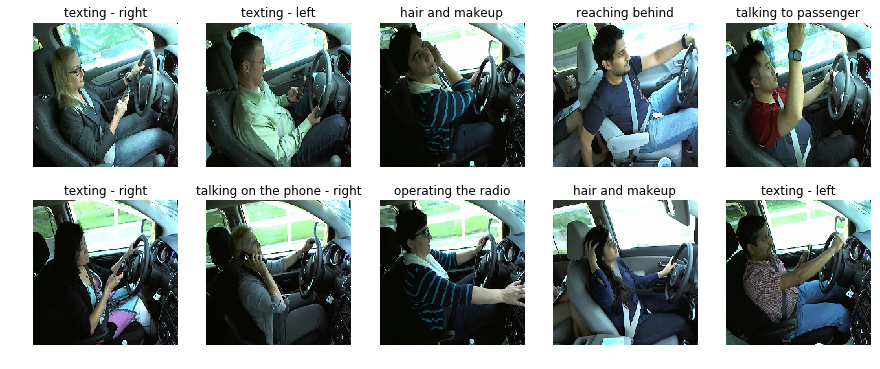

In [15]:
plot_classes(dset_loaders['train'], labels)

In [16]:
def plot_distribution(img):
    
    if img.shape[2] != 3:
        img = img.transpose((1, 2, 0))
        
    color_lst = ['red', 'green', 'blue']
    for i in range(0, img.shape[2]):
        c1=img[:,:,i].reshape(-1)
        plt.hist(c1, 50, facecolor=color_lst[i], label = color_lst[i])
    plt.legend()
    plt.grid(True)

In [17]:
def statistical_analysis_image(dset_loaders, labels, path2save = './figures/distribution.png'):

    fig = plt.figure(figsize=(15,6))
    inputs, cls = next(iter(dset_loaders))
    rand_idx = random.randrange(0, len(inputs))
    img = inputs.numpy()[rand_idx]
    img_denorm = denormalize(img)
    plt.subplot(2,2,2)
    plot_distribution(img_denorm)
    plt.title('Image RGB after denormalization')
    plt.subplot(2,2,4)
    plot_distribution(img)
    plt.title('Image RGB normalization')
    plt.subplot(1,2,1)
    img_denorm = np.clip(img_denorm, 0, 1.0)
    plt.imshow(img_denorm)
    plt.title('{}'.format(labels['c'+str(cls[rand_idx])]))
    plt.axis('off')
    fig.savefig(path2save)

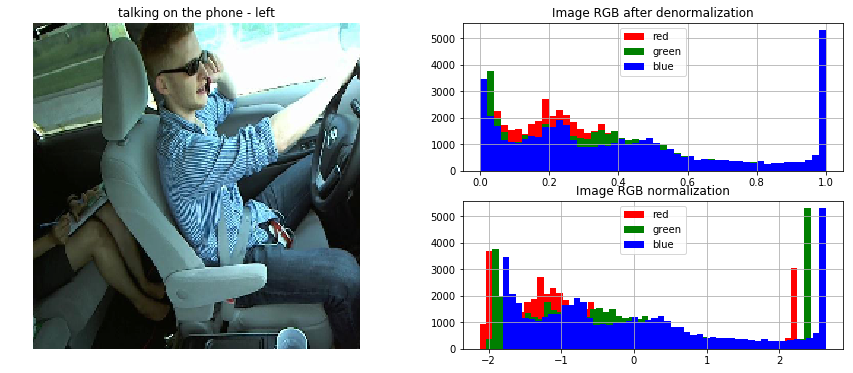

In [18]:
statistical_analysis_image(dset_loaders['train'], labels)

# Data Analysis

In [19]:
def code2label(dataset, labels): 
    class_str = []
    for item in dataset.y:
        class_str.append(labels['c'+str(item)])  
    return class_str           

In [20]:
class_str = code2label(dsets['train'], labels)

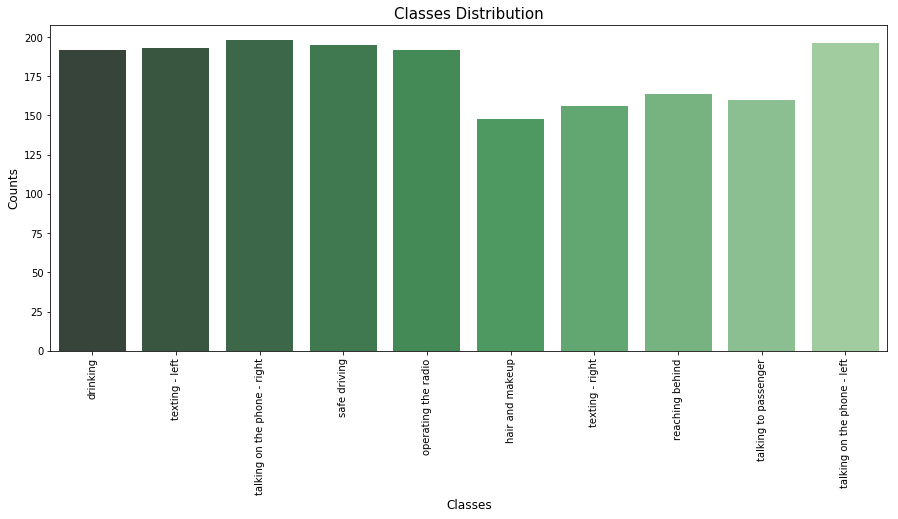

In [21]:
fig = plt.figure(figsize=(15,6))
sns.countplot(x=class_str, palette="Greens_d");
plt.xlabel("Classes", fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(rotation=90)
plt.title("Classes Distribution", fontsize=15)
plt.show()
path2save = './figures/distribution_classes.png'
fig.savefig(path2save)

In [22]:
nb_out = len(set(class_str))

In [23]:
"""

class Inception(torchvision.models.ResNet):
    def __init__(self, fixed_extractor = True):
        super().__init__(torchvision.models.inception_v3(pretrained=True))
        self.load_state_dict(torch.utils.model_zoo.load_url(
            'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth)')
        
        if fixed_extractor :
            for param in self.parameters():
                param.requires_grad = False


class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dens1 = torch.nn.Linear(in_features=64, out_features=32)
        self.dens2 = torch.nn.Linear(in_features=32, out_features=nb_out)
    def forward(self, x):
        x = self.dens1(x)
        x = torch.nn.functional.selu(x)
        x = self.dens2(x)
        return x



class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.inc = Inception()
        self.class = Classifier()
    def forward(self, x):
        x = self.inc(x)
        x = self.class(x)
        return x 
        
"""

"\n\nclass Inception(torchvision.models.ResNet):\n    def __init__(self, fixed_extractor = True):\n        super().__init__(torchvision.models.inception_v3(pretrained=True))\n        self.load_state_dict(torch.utils.model_zoo.load_url(\n            'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth)')\n        \n        if fixed_extractor :\n            for param in self.parameters():\n                param.requires_grad = False\n\n\nclass Classifier(torch.nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.dens1 = torch.nn.Linear(in_features=64, out_features=32)\n        self.dens2 = torch.nn.Linear(in_features=32, out_features=nb_out)\n    def forward(self, x):\n        x = self.dens1(x)\n        x = torch.nn.functional.selu(x)\n        x = self.dens2(x)\n        return x\n\n\n\nclass Model(torch.nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.inc = Inception()\n        self.class = Classifier()\n    def for

In [24]:
class MyResNetConv(torchvision.models.ResNet):
    def __init__(self, fixed_extractor = True):
        super().__init__(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2])
        self.load_state_dict(torch.utils.model_zoo.load_url(
            'https://download.pytorch.org/models/resnet18-5c106cde.pth'))
        
        del self.layer2
        del self.layer3
        del self.layer4
        del self.fc
        
        if fixed_extractor:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

class MyResNetDens(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dens1 = torch.nn.Linear(in_features=64, out_features=32)
        self.dens2 = torch.nn.Linear(in_features=32, out_features=nb_out)
    def forward(self, x):
        x = self.dens1(x)
        x = torch.nn.functional.selu(x)
        x = self.dens2(x)
        return x

class MyResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mrnc = MyResNetConv()
        self.mrnd = MyResNetDens()
    def forward(self, x):
        x = self.mrnc(x)
        x = self.mrnd(x)
        return x

# Verificando disponibilidade de recursos

In [116]:
model = MyResNet()
if use_gpu:
    !free -h
    !nvidia-smi
    model = torch.nn.DataParallel(MyResNet())
    model.cuda()


              total        used        free      shared  buff/cache   available
Mem:           220G         16G        198G        1.1G        5.3G        201G
Swap:            0B          0B          0B
Sun Nov 12 20:42:56 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00003609:00:00.0 Off |                    0 |
| N/A   42C    P0    72W / 149W |   2717MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00004BDC:0

In [117]:
print(model)

DataParallel (
  (module): MyResNet (
    (mrnc): MyResNetConv (
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
      (layer1): Sequential (
        (0): BasicBlock (
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
          (relu): ReLU (inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        )
        (1): BasicBlock (
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
          (relu): ReLU (inplac

In [118]:
def predict_convolutional(dset_loaders, model, get_labels = False):

    predictions = []
    labels_lst = []
    ii_n = len(dset_loaders)

    for i, (inputs, labels) in enumerate(dset_loaders):
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        inputs = Variable(inputs)
        predictions.append(model(inputs).data)
        if get_labels:
            labels_lst.append(labels)

        print('\rpredict: {}/{}'.format(i, ii_n - 1), end='')
    print(' ok')
    if len(predictions) > 0:
        return {'input': torch.cat(predictions, 0), 'ouput':torch.cat(labels_lst, 0) }

In [120]:
if use_gpu:
    convOutput_train = predict_convolutional(dset_loaders['train'], model.module.mrnc, get_labels= True)
    convOutput_valid = predict_convolutional(dset_loaders['valid'], model.module.mrnc, get_labels= True)
else:
    convOutput_train = predict_convolutional(dset_loaders['train'], model.mrnc, get_labels= True)
    convOutput_valid = predict_convolutional(dset_loaders['valid'], model.mrnc, get_labels= True)

predict: 56/56 ok
predict: 13/13 ok


In [121]:
print(convOutput_train['input'].size(), convOutput_train['ouput'].size())
print(convOutput_valid['input'].size(), convOutput_valid['ouput'].size())

torch.Size([1794, 4096]) torch.Size([1794])
torch.Size([448, 4096]) torch.Size([448])


In [122]:
conv_dset ={
    'train': TensorDataset(convOutput_train['input'], convOutput_train['ouput']),
    'valid': TensorDataset(convOutput_valid['input'], convOutput_valid['ouput'])
} 

In [123]:
len(dset_loaders_convnet['train'])

57

In [132]:
dset_loaders_convnet = _create_dataLoader(conv_dset, batch_size, cpu_count, pin_memory=use_gpu)

In [125]:
path2saveModel = '/home/r120084/project/models/distractdriver'
#path2saveModel = 'pathdoeuler' 

if use_gpu:    
    path2saveModel = '/mnt/home/r120084/project/models/distractdriver' 
    #path2saveModel = 'pathdoeuler' 
    
savebest = ptt.ModelCheckpoint(path2saveModel,reset=False, verbose=1)

In [126]:
if use_gpu:
    optimizer =  optim.Adam(model.module.mrnd.parameters(), lr=1e-3)
    
    params = {'model' : model.module.mrnd, 
        'criterion': loss_fn,  
        'optimizer': optimizer, 
        'callbacks': [savebest,  ptt.PrintCallback()] #ptt.PlotCallback(),
    }
    
else:    
    optimizer =  optim.Adam(model.mrnd.parameters(), lr=1e-3)
    params = {'model' : model.mrnd, 
        'criterion': loss_fn,  
        'optimizer': optimizer, 
        'callbacks': [savebest,  ptt.PrintCallback()] #ptt.PlotCallback(),
    }

scheduler = StepLR(optimizer, step_size=5, gamma=0.75)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 50

In [127]:
trainer = ptt.DeepNetTrainer(**params)

In [ ]:
trainer.fit_loader(num_epochs, dset_loaders_convnet['train'], dset_loaders_convnet['valid'])

In [ ]:
if use_gpu:
    !free -h
    !nvidia-smi

In [ ]:
path2save = './figures/results_metrics.png'

fig = plt.figure(figsize=(10,5))
metrics_map = {'losses': 'Loss', 'acc': 'Acuracy'}

metrics_eval_nb = len(trainer.metrics['train'].keys())
count = 1
for metric in trainer.metrics['train'].keys():
    plt.subplot(1,metrics_eval_nb, count)
    plt.plot(trainer.metrics['train'][metric], 'ob', label = 'train')
    plt.plot(trainer.metrics['valid'][metric], 'or', label = 'valid')
    count += 1
    plt.xlabel('Epochs', fontsize = 12)
    plt.ylabel(metrics_map[metric], fontsize = 12)
    plt.title(metrics_map[metric] + " during the model's training", fontsize = 16)
    plt.legend()
fig.savefig(path2save)

In [ ]:
train_eval = trainer.evaluate_loader(dset_loaders_convnet['train'])
valid_eval = trainer.evaluate_loader(dset_loaders_convnet['valid'])

In [ ]:
train_eval, valid_eval

In [ ]:
def predict_images(dset):

    output_true = []
    output_pred_lst = []
    correct = 0
    for i, (inputs, outputs) in enumerate(dset):
        if use_gpu:
            inputs = inputs.cuda()
            outputs = outputs.cuda()
        output_pred = trainer.predict(inputs)      
        _, predicted = torch.max(output_pred, 0)
        predicted = predicted.numpy()
        correct += (predicted == outputs)
        output_pred_lst.append(predicted[0])
        output_true.append(outputs)
    output_pred_lst = np.array(output_pred_lst)
    output_true = np.array(output_true)

    result = {'true': output_true, 'pred': output_pred_lst}
    return result

In [ ]:
result_train = predict_images(conv_dset['train'])
result_valid = predict_images(conv_dset['valid'])

In [ ]:
correct_train = (result_train['true'] == result_train['pred']).sum()
correct_valid = (result_valid['true'] == result_valid['pred']).sum()

In [ ]:
print('Train: ', correct_train, '/', len(conv_dset['train']) )
print('Valid: ', correct_valid, '/', len(conv_dset['valid']) )

In [ ]:
lst_correct = np.where(result_train['true'] == result_train['pred'])[0]
lst_incorrect = np.where(result_train['true'] != result_train['pred'])[0]

In [ ]:
def visualize_predictions(dsets, lst, path2save = []):

    fig = plt.figure(figsize=(15,6))
    for i, j in enumerate(range(0,4)):
        fig.add_subplot(1,4, i+1)
        (inputs, output) = dsets[lst[j]]
        img = denormalize(inputs.numpy())
        img = np.clip(img, 0, 1.0)
        plt.imshow(img)
        #plt.title('{0} / {1}'.format(labels['c'+str(output)],  labels[('c'+str(result_train['pred'][lst[j]]))]))    
        plt.title('{0} / {1}'.format(('c'+str(output)),  ('c'+str(result_train['pred'][lst[j]]))))    
        plt.axis('off')
    if len(path2save) !=0:
        fig.savefig(path2save)

In [ ]:
visualize_predictions(dsets['train'], lst_correct)

In [ ]:
visualize_predictions(dsets['train'], lst_incorrect)

In [ ]:
def plot_confusion(results):
    mc = np.array(pd.crosstab(results['pred'], results['true']))
    plt.imshow(mc/mc.sum(axis=1))
    plt.colorbar()
    plt.axis('off')

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plot_confusion(result_train)
plt.title('Train dataset')
plt.subplot(1,2,2)
plot_confusion(result_valid)
plt.title('Valid dataset')

In [ ]:
def plot_layers_weight(conv_model = model.mrnc, ncols = 8, H = 14, W=30):


    rand_idx = random.randrange(0, len(dsets['train']))
    input, _ = dsets['train'][rand_idx]
    input = input.view(1, 3, 50, 50)

    if use_gpu:
        x = Variable(input.cuda())
    else:
        x = Variable(input)


    for name, layer in conv_model.named_children():
        x = layer(x)
        grid = torchvision.utils.make_grid(torch.transpose(x.data, 0, 1), normalize=True, 
                                           pad_value=1.0, padding=1).cpu().numpy()

        if name == 'max_pool':
            H /= 3/2
            W /= 3/2
        fig = plt.figure(figsize=(H,W))
        plt.imshow(grid.transpose((1,2,0)))
        plt.title(name)
        plt.axis('off')
        plt.show()

In [ ]:
plot_layers_weight()